In [1]:
import numpy as np
import os, cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.utils import shuffle
from imutils import build_montages
from keras.datasets import mnist
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.layers import BatchNormalization, Input, LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.core import Activation, Dense, Flatten, Reshape
from tensorflow.keras.models import load_model

# 1 - Implement DCGAN

In [2]:
class DCGAN:
    
    """Build the generator module
    Arguments:
        dim:        the target spatial dimensions (width & height) of the generator after reshaping
        depth:      the target depth of the volumn after reshaping
        channels:   the number of channels in the output volume from the generator (1: grayscale, 3: RGB)
        inputDim:   dimensionality of the randomly generated input vector to the generator
        outputDim:  dimensionality of the output fully-connected layer from the randomly generated input vector
    """
    @staticmethod
    def build_generator(dim, depth, channels=1, inputDim=100, outputDim=512):
        #initialize the model
        model = Sequential()
        inputShape = (dim, dim, depth)
        chanDim = -1
        #1st FC layer: fully-connected -> relu -> normalization
        model.add(Dense(input_dim=inputDim, units=outputDim))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        #2nd FC layer: fully-connected -> relu -> normalization
        model.add(Dense(units=dim*dim*depth))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        #1st conv layer: reshape -> Conv2d -> relu -> normalization
        model.add(Reshape(inputShape))
        model.add(Conv2DTranspose(32,(5,5), strides=(2,2), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        #output layer: Conv2d -> tanh
        model.add(Conv2DTranspose(channels,(5,5),strides=(2,2),padding="same"))
        model.add(Activation("tanh"))
        return model
    

    @staticmethod
    def build_discriminator(width, height, depth, alpha=0.2):
        #initialize the model
        model = Sequential()
        inputShape = (height, width, depth)
        #1st conv layer: Conv2d -> leakyrelu
        model.add(Conv2D(32,(5,5),padding="same",strides=(2,2),input_shape=inputShape))
        model.add(LeakyReLU(alpha=alpha))
        #2nd conv layer: Conv2d -> leakyrelu
        model.add(Conv2D(64,(5,5),padding="same",strides=(2,2)))
        model.add(LeakyReLU(alpha=alpha))
        #1st FC layer: fully-connected -> leakyrelu
        model.add(Flatten())
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=alpha))
        #output model
        model.add(Dense(1))
        model.add(Activation("sigmoid"))
        return model

# 2 - Training on MNIST

## 2.1 Configuration

In [3]:
timestamp = (datetime.now()).strftime("%y%m%d_%H%M%S")
output_path = os.path.join("output", 'DCGAN_'+timestamp)
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [4]:
OUTPUT = output_path
NUM_EPOCHS = 25 
BATCH_SIZE = 128 

## 2.2 Load MNIST

In [5]:
print("[INFO] loading MNIST dataset...")
((trainX, _), (testX, _)) = mnist.load_data()
trainImages = np.concatenate([trainX, testX])
trainImages = np.expand_dims(trainImages, axis=-1)
trainImages = (trainImages.astype("float") - 127.5) / 127.5

[INFO] loading MNIST dataset...


## 2.3 - Initialize DCGAN

In [6]:
print("[INFO] building genertor...")
gen = DCGAN.build_generator(7, 64, channels=1)

print("[INFO] building discriminator...")
disc = DCGAN.build_discriminator(28, 28, 1)
optimizer = Adam(learning_rate=0.0002, beta_1=0.5, decay=0.0002/NUM_EPOCHS)
disc.compile(loss="binary_crossentropy", optimizer=optimizer)

[INFO] building genertor...
[INFO] building discriminator...


In [7]:
print("[INFOR] building GAN...")
disc.trainable = False
ganInput = Input(shape=(100,))
ganOutput = disc(gen(ganInput))
gan = Model(ganInput, ganOutput)

#Compile the GAN
ganOpt = Adam(learning_rate=0.0002, beta_1=0.5, decay=0.0002/NUM_EPOCHS)
gan.compile(loss="binary_crossentropy", optimizer=optimizer)

[INFOR] building GAN...


## 2.4 - Training

In [8]:
print("[INFO] starting training...")
benchmarkNoise = np.random.uniform(-1, 1, size=(256, 100))
disc_loss_list = []
gan_loss_list = []

# loop over the epochs
for epoch in range(NUM_EPOCHS):
    batchesPerEpoch = int(trainImages.shape[0]/BATCH_SIZE)
    
    #loop over the batches
    for i in range(0, batchesPerEpoch):
        p = None        #initialize an empty output path

        # select the next batch of images, then randomly generate noise for the generator to predict on
        imageBatch = trainImages[i * BATCH_SIZE:(i+1) * BATCH_SIZE]
        noise = np.random.uniform(-1,1,size=(BATCH_SIZE,100))

        # generate image using noise + generator model
        genImages = gen.predict(noise, verbose=0)

        # concatenate the *actual* images and the *generated* images, 
        # construct class labels for the discriminator, and shuffle
        X = np.concatenate((imageBatch, genImages))
        y = np.array(([1]*BATCH_SIZE) + ([0]*BATCH_SIZE))
        (X, y) = shuffle(X,y)

        # train the discriminator
        discLoss = disc.train_on_batch(X, y)

        # train the generator by generate randome noise & freeze discriminator
        noise = np.random.uniform(-1, 1, (BATCH_SIZE, 100))
        ganLoss = gan.train_on_batch(noise, np.array([1]*BATCH_SIZE))


        # if end of an epoch, create path for output image
        if i == (batchesPerEpoch - 1):
            if (epoch+1)%5 == 0 or epoch==0:
                p = [OUTPUT, "epoch_{}_output.png".format(str(epoch+1).zfill(4))]
            
            disc_loss_list.append(discLoss)
            gan_loss_list.append(ganLoss)
            print(f"[INFO] Epoch {epoch+1:02d}: disc_loss={discLoss:.6f}, gan_loss:{ganLoss:.6f}")
        
        if p is not None:
            images = gen.predict(benchmarkNoise, verbose=False)
            images = ((images*127.5)+127.5).astype("uint8")
            images = np.repeat(images,3,axis=-1)
            vis = build_montages(images, (28,28), (16,16))[0]
            p = os.path.sep.join(p)
            cv2.imwrite(p, vis)

[INFO] starting training...
[INFO] Epoch 01: disc_loss=0.397715, gan_loss:1.997550
[INFO] Epoch 02: disc_loss=0.461168, gan_loss:0.877811
[INFO] Epoch 03: disc_loss=0.520838, gan_loss:1.028584
[INFO] Epoch 04: disc_loss=0.517407, gan_loss:1.190240
[INFO] Epoch 05: disc_loss=0.489175, gan_loss:1.147896
[INFO] Epoch 06: disc_loss=0.532778, gan_loss:1.295194
[INFO] Epoch 07: disc_loss=0.506199, gan_loss:1.197796
[INFO] Epoch 08: disc_loss=0.519986, gan_loss:1.320543
[INFO] Epoch 09: disc_loss=0.526153, gan_loss:1.246445
[INFO] Epoch 10: disc_loss=0.548838, gan_loss:1.336514
[INFO] Epoch 11: disc_loss=0.517089, gan_loss:1.376884
[INFO] Epoch 12: disc_loss=0.528526, gan_loss:1.294966
[INFO] Epoch 13: disc_loss=0.502219, gan_loss:1.136060
[INFO] Epoch 14: disc_loss=0.573874, gan_loss:1.138325
[INFO] Epoch 15: disc_loss=0.528034, gan_loss:1.463580
[INFO] Epoch 16: disc_loss=0.534811, gan_loss:1.268294
[INFO] Epoch 17: disc_loss=0.561287, gan_loss:1.407249
[INFO] Epoch 18: disc_loss=0.519469, 

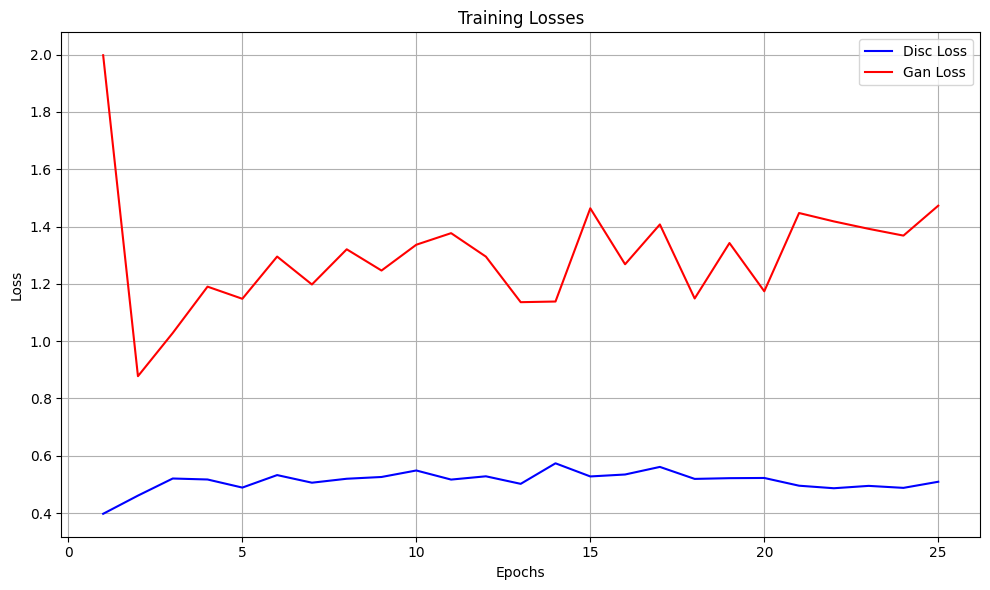

In [9]:
# Example lists of losses (replace with your actual lists)
epochs = range(1, len(disc_loss_list)+1)  # Assuming both lists have the same length

# Plotting losses
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(epochs, disc_loss_list, 'b', label='Disc Loss')
plt.plot(epochs, gan_loss_list, 'r', label='Gan Loss')
plt.title('Training Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 2.5 - Saving model

In [10]:
# After training loop, save the generator and discriminator models
print("[INFO] saving models...")

# Define the paths to save the models
gen_model_path = os.path.join(OUTPUT, "generator_model.h5")
disc_model_path = os.path.join(OUTPUT, "discriminator_model.h5")

# Compile the models before saving
gen.compile(optimizer=optimizer, loss='binary_crossentropy')
disc.compile(optimizer=optimizer, loss='binary_crossentropy')

# Save the models
gen.save(gen_model_path)
disc.save(disc_model_path)

print(f"[INFO] generator model saved to {gen_model_path}")
print(f"[INFO] discriminator model saved to {disc_model_path}")

[INFO] saving models...
[INFO] generator model saved to output\DCGAN_240701_005534\generator_model.h5
[INFO] discriminator model saved to output\DCGAN_240701_005534\discriminator_model.h5


# 3 - Test on MNIST

In [11]:
"""In case you just need to test the model without training:
- modify the OUTPUT param below to the directory of your trained model
- remember to run the first block which contains all libraries importing"""
# OUTPUT = ''

'In case you just need to test the model without training:\n- modify the OUTPUT param below to the directory of your trained model\n- remember to run the first block which contains all libraries importing'

In [12]:
# Load the saved models
gen_model_path = os.path.join(OUTPUT, "generator_model.h5")
disc_model_path = os.path.join(OUTPUT, "discriminator_model.h5")

gen_load = load_model(gen_model_path)
disc_load = load_model(disc_model_path)

# Function to generate an image and get discriminator prediction
def generate_and_predict(num_img):
    noise = np.random.uniform(-1, 1, (num_img, 100))
    
    # Generate images using the generator
    gen_images = gen_load.predict(noise, verbose=False)
    gen_images = ((gen_images * 127.5) + 127.5).astype("uint8")
    
    # Predict authenticity using the discriminator
    preds = disc.predict(gen_images.reshape(num_img, 28, 28, 1), verbose=False)
    
    # Calculate losses
    disc_loss = np.mean(preds)
    print(f"Average Discriminator loss: {disc_loss:.6f}")
    
    # Display the generated images and predictions
    plt.figure(figsize=(2*num_img, 2.5))
    for i in range(num_img):
        plt.subplot(1, num_img, i + 1)
        plt.imshow(gen_images[i].squeeze(), cmap='gray')
        plt.title(f"Disc: {preds[i][0]:.4f}")
        plt.axis('off')
    plt.show()

Average Discriminator loss: 1.000000


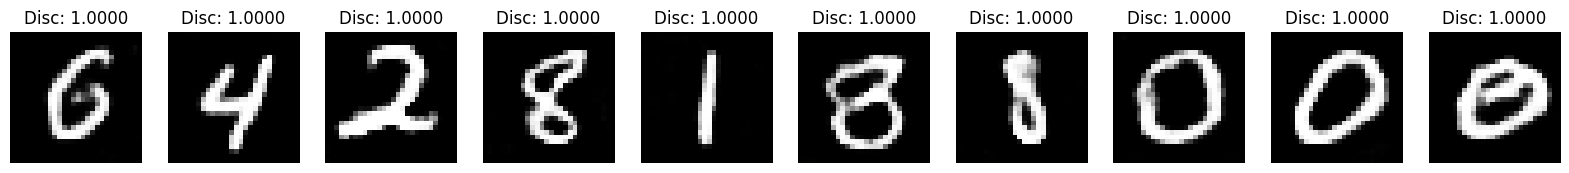

In [15]:
generate_and_predict(10) #Randomly generate 10 image